In [2]:
import numpy as np
import pandas as pd
import configparser
config = configparser.ConfigParser()

In [5]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [9]:
config.read("../../env.ini")
data_home = config['DEFAULT']['data_home']
local_lib = config['DEFAULT']['local_lib']
data_directory = f"{data_home}/woolf"

## Word2vec

In [19]:
!pip install --upgrade gensim==4.3.3

In [22]:
!pip install threadpoolctl==3.1.0

In [24]:
import gensim
gensim.__version__

'4.3.3'

In [26]:
import numpy as np
import pandas as pd
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px
from IPython.display import display, Image

In [38]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4]
SENT = OHCO[:5]
BAG = PARA # using paragraph as bag this time

In [30]:
# word2vec parameters

w2v_params_a = dict(
    window = 2,
    vector_size = 256,
    min_count = 50)

w2v_params_m = dict(
    window = 2,
    vector_size = 256,
    min_count = 80)

In [32]:
TOKEN = pd.read_csv(f'woolf-CORPUS.csv').set_index(OHCO)
TOKEN = TOKEN[TOKEN['pos'].isin(['NNS','NN','VB','VBD','VBN','VBG','VBP','VBZ'])]

LIB = pd.read_csv(f'woolf-LIB.csv')

In [34]:
merged = TOKEN.reset_index().merge(LIB, on='book_id').set_index(TOKEN.index.names)

In [40]:
# Convert to gensim corpora

docs = merged.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]

In [46]:
VOCAB_W2V = merged.term_str.value_counts().to_frame('n')
VOCAB_W2V['pos_max'] = merged.groupby(['term_str','pos']).pos.count().unstack().idxmax(axis=1)
VOCAB_W2V['pos_group'] = VOCAB_W2V['pos_max'].str[:2]

In [48]:
VOCAB_W2V

,n,pos_max,pos_group
was,6431,VBD,VB
had,4099,VBD,VB
said,2494,VBD,VB
were,1923,VBD,VB
be,1727,VB,VB
...,...,...,...
dizziness,1,NN,NN
throng,1,NN,NN
concocting,1,VBG,VB
incantations,1,NNS,NN


In [50]:
model = word2vec.Word2Vec(docs, **w2v_params_a)

In [54]:
model

In [56]:
# Generate tables of tSNE coordinates

def get_vector(row, mod):
    w = row.name
    try:
        return mod.wv[w]
    except KeyError:
        return np.zeros(mod.vector_size)

In [60]:
WV = pd.DataFrame(VOCAB_W2V.apply(lambda row: get_vector(row, model), axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [64]:
tsne_engine = tsne(learning_rate=200, perplexity=20, n_components=2, init='random', n_iter=1000, random_state=42)

tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [67]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [71]:
# Join with VOCAB table

VOCAB_W2V = VOCAB_W2V.reset_index().merge(TSNE.reset_index(), on='index').set_index('index')
VOCAB_W2V.index.names = ['term_str']

In [73]:
VOCAB_W2V

,n,pos_max,pos_group,x,y
term_str,,,,,
was,6431,VBD,VB,8.971297,-15.539820
had,4099,VBD,VB,8.759276,-15.641277
said,2494,VBD,VB,6.041315,-16.923420
were,1923,VBD,VB,9.024520,-15.514286
be,1727,VB,VB,6.544348,-16.687191
...,...,...,...,...,...
dizziness,1,NN,NN,-0.214054,0.483171
throng,1,NN,NN,-0.947050,2.375409
concocting,1,VBG,VB,-0.004347,0.737213


In [84]:
model.vector_size

256

In [88]:
WV.sample()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
aboutit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# 256 features generated

In [96]:
WV.index.name = 'term_str'
VOCAB_W2V = VOCAB_W2V.join(WV, how='inner')

In [100]:
# Final VOCAB_W2V table with tsne coordinates AND all word2vec features

VOCAB_W2V

,n,pos_max,pos_group,x,y,0,1,2,3,4,...,246,247,248,249,250,251,252,253,254,255
term_str,,,,,,,,,,,,,,,,,,,,,
was,6431,VBD,VB,8.971297,-15.539820,-0.046173,-0.134142,0.081863,0.021670,0.191200,...,0.113123,0.072138,-0.003516,-0.123468,-0.092136,0.114484,-0.071873,-0.076369,-0.230562,0.015874
had,4099,VBD,VB,8.759276,-15.641277,-0.032022,-0.141876,0.055981,0.027176,0.207371,...,0.133730,0.045923,-0.008692,-0.115596,-0.089012,0.142005,-0.084565,-0.104279,-0.240217,0.006296
said,2494,VBD,VB,6.041315,-16.923420,0.020233,-0.061073,0.064892,0.047108,0.179994,...,0.086699,0.048643,0.018517,-0.113617,-0.130622,0.113103,-0.067549,-0.065259,-0.211080,0.051254
were,1923,VBD,VB,9.024520,-15.514286,-0.036050,-0.130933,0.089299,0.015811,0.201237,...,0.111106,0.084815,-0.003628,-0.124602,-0.094927,0.108394,-0.058572,-0.066260,-0.218618,0.020555
be,1727,VB,VB,6.544348,-16.687191,-0.003086,-0.078305,0.069853,0.036976,0.194155,...,0.104923,0.059509,0.015646,-0.120042,-0.117723,0.116286,-0.068921,-0.077438,-0.223265,0.033731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dizziness,1,NN,NN,-0.214054,0.483171,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
throng,1,NN,NN,-0.947050,2.375409,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
concocting,1,VBG,VB,-0.004347,0.737213,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### SAVE TABLE TO FILES

In [114]:
VOCAB_W2V.to_csv('woolf-VOCAB_W2V.csv')

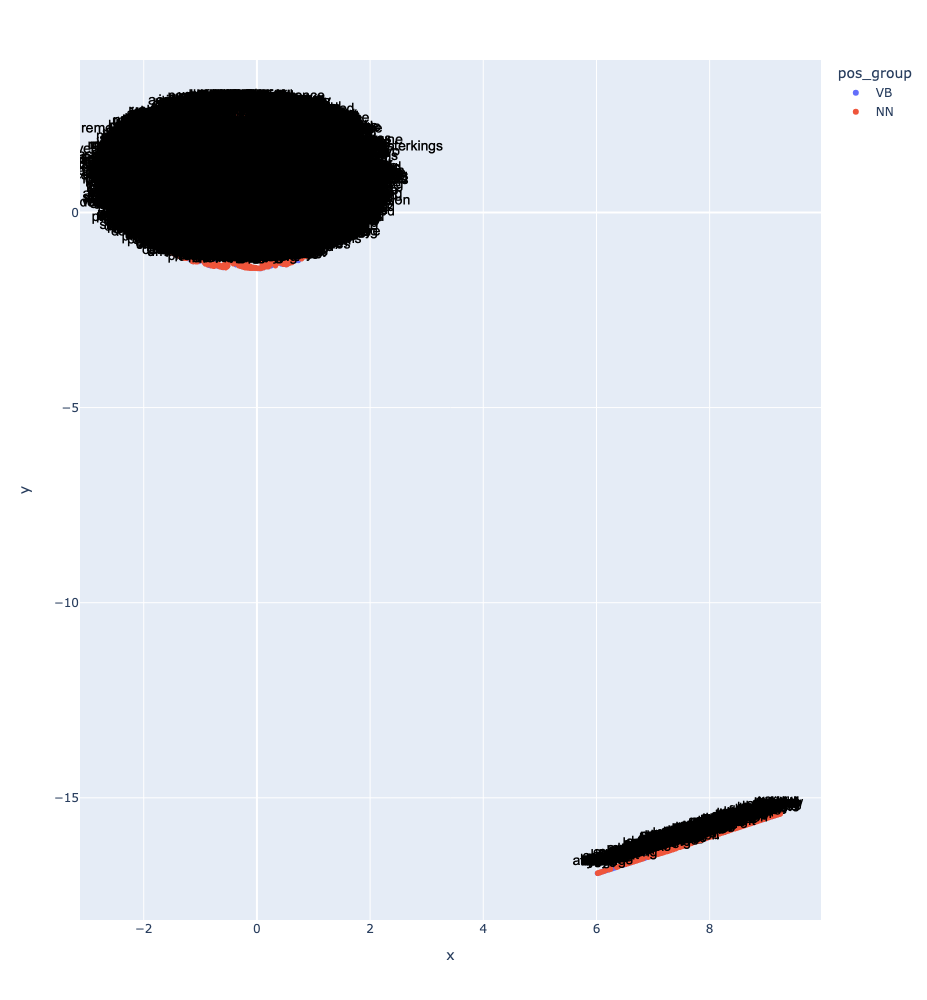

In [125]:
# tsne plot

# Visualize

px.scatter(VOCAB_W2V.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')